In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
reload(database)
db = database.thomas_18_db

In [3]:
figdir='/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_imaging_stability'
figdir= misc.get_or_create_subdir(figdir)

/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_imaging_stability


In [4]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

In [5]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)
import get_thomas_cell_metrics as gtcm
reload(gtcm)
import unimodal_nmf as unmf

In [6]:
import matplotlib
matplotlib.rcParams['svg.fonttype']='none'

In [7]:
# load firing related data
import detect_field_within_minus_outside_one_exp as dfwmooe
save_data_dir = '/mnt/home/szheng/ceph/place_variability/data/thomas18'
save_data_fn = f'{dfwmooe.SAVE_FN[:-2]}_combined.p'
res=pickle.load(open(os.path.join(save_data_dir,save_data_fn),'rb'))


field_bounds_all=    res['field_bounds_all']
threshold_all=    res['threshold_all']
in_field_mask_all=    res['in_field_mask_all']
out_field_mask_all=    res['out_field_mask_all']
all_day_activation_d_all=    res['all_day_activation_d_all']


/mnt/home/szheng/projects/place_variability/code/thomas_18_data/detect_field_within_minus_outside_one_exp.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  db_grouped = db.groupby(['region','exp_ind']).mean().index # group on the level of region and exp


In [8]:
%%time
reload(fmtas)
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=False,bin_size=0.022,gauss_width=0.2,save_fn_one='fr_map_mask_True_smallbin_smallgauss.p',save_fn_all='fr_map_mask_True_smallbin_smallgauss.p')
# fr_map_all = fmtas.main(force_reload=False,load_only=False,dosave=False)
fr_map_trial_df_all = fr_map_all['fr_map_trial_df_all']

occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']

# reshape fr_map_trial_df_all to make it easier to work with
fr_map_trial_df_all_day =fr_map_trial_df_all.unstack(level=2).swaplevel(0,1,axis=1).sort_index(axis=1) # day in column

fr_map_trial_df_all_per_uid=fr_map_trial_df_all.unstack(level=(2,3)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')

frmap_all_day = frmap.unstack(level=2).swaplevel(0,1,axis=1).sort_index(level=0,axis=1)

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_mask_True_smallbin_smallgauss.p exists; loading---
CPU times: user 27.9 s, sys: 14.5 s, total: 42.4 s
Wall time: 1min 17s


In [9]:
# get switch
import place_field_detection_thomas as pfdt
# trial_range = 5
# sw_on_ma,field_not_present_per_trial = pfdt.get_sw_ma(all_day_activation_d_all,1,threshold_all,trial_range=trial_range,field_not_present_frac=0.8,sw='on')
# # sw_off_ma,_ = pfdt.get_sw_ma(all_day_activation_d_all,0,threshold_all,trial_range=trial_range,field_not_present_frac=0.8,sw='off')
# sw_off_ma,_ = pfdt.get_sw_ma_per_session(all_day_activation_d_all,0,threshold_all,trial_range=trial_range,field_not_present_frac=0.8,sw='off')



# sw_on_ma = sw_on_ma.loc[(slice(None),slice(None),slice(None),slice(None),1)]
# sw_off_ma = sw_off_ma.loc[(slice(None),slice(None),slice(None),slice(None),0)]

In [10]:
# get baseline F0
# consider move to main code in prep_thomas_data
def get_F0_one_exp_one_cat(f,exp_ind=0,day_ind=0,famnov=0,region='CA1'):
    one_exp=f[f['data']['CA1'][exp_ind,0]]
    cells_oneexp=one_exp['cells']
    n_uid = one_exp['cells'].shape[0]
    sess_ind = day_ind * 2 + famnov
    F0_alltrials_allcells = []
    for uid in range(n_uid):
        one_cell = f[one_exp['cells'][uid,0]]
        one_cell_cat = f[one_cell['categories'][sess_ind,0]]
        F0_alltrials=np.concatenate([f[f0] for f0 in np.squeeze(one_cell_cat['F0'])])
        F0_alltrials_allcells.append(np.squeeze(F0_alltrials))
    F0_alltrials_allcells = np.stack(F0_alltrials_allcells)
    return F0_alltrials_allcells
        
        

In [11]:
import h5py
fn_full = '/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1.h5'
f = h5py.File(fn_full, 'r')

def get_roi_one_exp(f,exp_ind,region='CA1'):
    '''
    roi_com_all: n_cell x 2
    '''
    one_exp=f[f['data']['CA1'][exp_ind,0]]
    cells_oneexp=one_exp['cells']
    n_uid = one_exp['cells'].shape[0]
    roi_com_all = []
    for uid in range(n_uid):
        roi=f[cells_oneexp[uid,0]]['roi']
        mnCooordinates=roi['mnCoordinates']
        # f[mnCooordinates]
        mnCooordinates_com=np.array(mnCooordinates).mean(axis=1)
        roi_com_all.append(mnCooordinates_com)
    roi_com_all = np.array(roi_com_all)
    return roi_com_all


region = 'CA1'
# exp_ind=8#0
exp_ind=8#0
famnov=0

# get roi com
roi_com_all=get_roi_one_exp(f,exp_ind=exp_ind,region='CA1')

from scipy.spatial.distance import pdist,squareform

# sw_on_ma_onesess=sw_on_ma.loc[region,exp_ind,famnov]
# sw_on_uid_onesess=sw_on_ma_onesess[sw_on_ma_onesess].index.get_level_values(0)


dist = squareform(pdist(roi_com_all))
# uid_l=sw_on_ma_onesess.index.get_level_values(0).unique()
dist[np.diag_indices_from(dist)]=np.nan
dist=pd.DataFrame(dist)

# write a funtion that give the sw_on and sw_off trial

In [278]:
all_day_activation_sub_unstack=all_day_activation_sub.unstack() # uid x (ntrial, nfield)
uid_avail=all_day_activation_sub_unstack.index
threshold_sub_uid_avail =threshold_sub.loc[uid_avail]
all_day_activation_sub >= threshold_sub_uid_avail

/tmp/ipykernel_936083/2431052049.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  all_day_activation_sub>=threshold_sub_uid_avail


0      1      2      3      4      5      6      7      8      9     \
0    0   True   True  False  False  False   True  False  False   True   True   
1    0   True   True  False  False   True  False  False  False   True   True   
2    0   True   True   True  False   True   True   True   True   True   True   
4    0   True   True   True  False   True   True  False   True   True   True   
     1   True   True   True  False   True   True   True   True   True   True   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1763 2   True   True   True  False  False  False  False  False   True   True   
     3   True   True  False  False   True  False  False  False  False   True   
1764 0   True  False   True  False  False  False   True  False   True  False   
     1   True  False  False  False  False  False  False  False  False  False   
     2  False   True  False  False  False   True  False  False  False  False   

        ...   1755   1756   1757   1758   1759   1760   1761   1762   1763  \
0    0  ...  False  False  False  False  False  False  False  False  False   
1    0  ...  False  False  False  False  False  False  False  False  False   
2    0  ...  False  False  False  False  False  False  False  False  False   
4    0  ...  False  False  False  False  False  False  False  False  False   
     1  ...  False  False  False  False  False  False  False  False  False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1763 2  ...  False  False  False  False  False  False  False  False  False   
     3  ...  False  False  False  False  False  False  False  False  False   
1764 0  ...  False  False  False  False  False  False  False  False  False   
     1  ...  False  False  False  False  False  False  False  False  False   
     2  ...  False  False  False  False  False  False  False  False  False   

         1764  
0    0  False  
1    0  False  
2    0  False  
4    0  False  
     1  False  
...       ...  
1763 2  False  
     3  False  
1764 0  False  
     1  False  
     2  False  

[2828 rows x 1522 columns]

In [ ]:
get_field_day = 0
threshold_sub = threshold_all.loc[(region,exp_ind,famnov,slice(None),get_field_day)]

left,right=threshold_sub.align(all_day_activation_sub,axis=0,level=0)
field_present_per_trial_sub=right>=left.values[:,None] # (n_neuron, n_field) x n_trial

# current problem, want to include the detect field above threshold inside the get_switch_trial function, 
# cause currently passing around field_present_per_trial_sub, often errored;

In [96]:
# #### Although this method is closer to the main figure. HOWEVER!!! Most neurons would be determined to switch immediately after the window 
# #### we specify. So not using

# def get_switch_trial_based_on_mask(
#     all_day_activation_sub,
#     threshold_sub,
#     trial_range = 5,
#     field_not_present_frac=0.8,
#     sw='on',
#         ):
#     '''
#     a looser but closer to the original way:
#     define switch based on the mask, find the first "present" trial after the initial window (on), 
#                                         or the last "present" trial before the last window (off)
#     '''
    
    
#     all_day_activation_sub = all_day_activation_sub.dropna(axis=1,how='all')
#     ntrial = all_day_activation_sub.shape[1]
#     left,right=threshold_sub.align(all_day_activation_sub,axis=0,level=0)
#     field_not_present_per_trial_sub=right<left.values[:,None] # (n_neuron, n_field) x n_trial
#     field_present_per_trial_sub = np.logical_not(field_not_present_per_trial_sub)
    
#     if sw=='on':
#         sw_ma = field_not_present_per_trial_sub.iloc[:,:trial_range].mean(axis=1) >=field_not_present_frac
        
#     elif sw=='off':
#         sw_ma = field_not_present_per_trial_sub.iloc[:,-trial_range:].mean(axis=1) >=field_not_present_frac

#     sw_uid = sw_ma.loc[sw_ma].index
#     sw_trial_l = {}
#     for (uid,field_id) in sw_uid:
#         row=field_present_per_trial_sub.loc[(uid,field_id),:]
#         present_tr_ind = np.nonzero(row.values)[0]
#         present_tr=field_present_per_trial_sub.columns[present_tr_ind]
#         if sw=='on':
#             sw_tr = present_tr[present_tr>(trial_range-1)][0] # first present tr after the initial window
#         elif sw=='off':
#             sw_tr = present_tr[present_tr<(ntrial-trial_range)][-1] # last present tr before the end window
            
#         sw_trial_l[uid,field_id] = sw_tr
#     return sw_trial_l
        
    

In [12]:
def get_switch_trial(
    all_day_activation_sub,
    threshold_sub,
    sw_mag_thresh=0.4,
    trial_range = 5,
    field_present_frac = 0.6,
    field_not_present_frac=0.8,
    sw='on',
    ):
    # get switch on trial; criterion from pfdt.get_sw_ma (first 4 (80% of window=5) trials below thresh), 
    # in addition, find the first trial post the 5th, such that 3 trials within 5 trials are above thresh
    # in addition, the switch trial has to be 0.4 above the previous trial in normalized(by max within field) dF/F
    
    # for off trial: 
    # criterion from pfdt.get_sw_ma (last 4 (80% of window=5) trials below thresh), 
    # in addition, find the last trial before the 5th to last, such that 3 trials within 5 trials are below thresh
    # in addition, the switch trial has to be 0.4 below the previous trial in normalized(by max within field) dF/F
    
    all_day_activation_sub = all_day_activation_sub.dropna(axis=1,how='all')
    
    left,right=threshold_sub.align(all_day_activation_sub,axis=0,level=0)
    field_present_per_trial_sub=right>=left.values[:,None] # (n_neuron, n_field) x n_trial

    
    all_day_activation_sub_norm = all_day_activation_sub / all_day_activation_sub.max(axis=1).values[:,None]
    all_day_activation_sub_norm = all_day_activation_sub_norm.dropna(axis=1,how='all')
    field_present_per_trial_sub=field_present_per_trial_sub[all_day_activation_sub_norm.columns] # sneaky! field_present_per_trial_sub already replaced things with 0
    
    # number of trials where the field is present in the next window
    n_present_in_next_win= scipy.signal.convolve(field_present_per_trial_sub,np.ones(trial_range,dtype=int)[None,:],mode='full')[:,trial_range-1:]
    n_present_in_next_win = pd.DataFrame(n_present_in_next_win,index=field_present_per_trial_sub.index,columns=field_present_per_trial_sub.columns)
    
    sw_on_trial_l = {}
    for (uid,field_id),row in field_present_per_trial_sub.iterrows():
        activation_row=all_day_activation_sub_norm.loc[(uid,field_id),:]
        if sw=='on':
            ma_not_already_on = np.logical_not(row).iloc[:trial_range].sum()>=int(field_not_present_frac*trial_range)
            first_crit = ma_not_already_on
        elif sw=='off':
            # ma for if the field is indeed off at the end
            ma_off_end = np.logical_not(row).iloc[-trial_range:].sum()>=int(field_not_present_frac*trial_range)
            first_crit = ma_off_end
#         if ma_not_already_on:
        if first_crit:
            if sw=='on':
                ma_window=n_present_in_next_win.loc[(uid,field_id)]>=int(trial_range*field_present_frac)
                ma_magnitude = activation_row.diff()>=sw_mag_thresh
            elif sw=='off': # next window of trials, the number of trials above threshold should be below a number
                ma_window=n_present_in_next_win.loc[(uid,field_id)]<=int(trial_range*(1-field_present_frac))
                ma_magnitude = activation_row.diff()<=-sw_mag_thresh
            ma = np.logical_and(row.values,ma_window)
            ma=np.logical_and(ma,ma_magnitude)
            ind_above_thresh=np.nonzero(ma.values)[0]
            if len(ind_above_thresh)>0:
                if sw=='on':
                    first_above_thresh=ind_above_thresh[0]
                    if first_above_thresh>=trial_range:
                        sw_on_trial_l[(uid,field_id)] = first_above_thresh
                elif sw=='off': 
                    last_below_thresh=ind_above_thresh[-1]

                    if last_below_thresh<=all_day_activation_sub_norm.shape[1]-trial_range: 
                        sw_on_trial_l[(uid,field_id)] = last_below_thresh

    return sw_on_trial_l # or sw_off_trial_l


In [159]:
def get_F0_change_neighbors(F0_df,dist,sw_trial_l,radius=10):
    '''
    # for each switch on, get the change in F0 in adjacent neurons/population
    # test (sw trial-(sw-1)) vs ((sw-1) - (sw-2)), also vs (sw+1 - sw)
    # look at the mean absolute change of the neighbors; treat one switch as one data point
    
    F0_df: n_neuron x n_trial, baseline Fluorescence, from get_F0_one_exp_one_cat
    dist: df, n_neuron x n_neuron, pairwise distance between roi com
    '''
    F0_change_all = {}
#     F0_df = F0_alltrials_allcells_z
    F0_df_diff=F0_df.diff(axis=1).dropna(axis=1,how='all')
#     pval_all = {}

    for (uid,field_id), tr in sw_trial_l.items():
        
#         #### testing!!! [[remember to turn off!!!!]]
#         tr = np.random.randint(6,10)
#         tr = np.random.randint(4,10)
        tr = np.random.randint(2,7)
#         tr = 7
        
        ma =dist.loc[uid] < radius
#         ma =dist.loc[uid] < 1000
        uid_close=ma.index[ma]
#         uid_close=uid_close.difference(sw_on_uid_onesess)

        # test (sw-(sw-1)) - ((sw-1) - (sw-2))
        F0_change_uid_close_sw = F0_df.loc[uid_close,tr] - F0_df.loc[uid_close,tr-1]
        F0_change_uid_close_beforesw = F0_df.loc[uid_close,tr-1] - F0_df.loc[uid_close,tr-2]
        F0_change_uid_close_aftersw = F0_df.loc[uid_close,tr+1] - F0_df.loc[uid_close,tr]

    #     F0_change_uid_close_sw=F0_df_diff.loc[uid_close,tr]
    #     F0_change_uid_close_othertr = F0_df_diff.loc[uid_close,F0_df_diff.columns!=tr]
    #     F0_change_uid_close_abs_othertr_minus_sw = F0_change_uid_close_othertr.abs() - F0_change_uid_close_sw.abs().values[:,None]

        # test for each neighbor neurons, whether the abs F0 change at switch trial is sig. higher than the rest of the trials
    #     _,pval=scipy.stats.wilcoxon(F0_change_uid_close_abs_othertr_minus_sw.T)
    #     pval_all[uid] = pd.Series(pval,index=uid_close)

    # pval_all = pd.concat(pval_all)

        F0_change_all[uid] = pd.concat({'before':F0_change_uid_close_beforesw,'sw':F0_change_uid_close_sw,'after':F0_change_uid_close_aftersw},axis=1)
    F0_change_all = pd.concat(F0_change_all,axis=0)
    diff=F0_change_all.abs().groupby(level=0).mean().diff(axis=1) # absolute difference, averaged among neighbors
    return F0_change_all,diff
    

In [160]:
from scipy.spatial.distance import pdist,squareform
def analyze_neighbor_mean_abs_F0_change(f,
                                        threshold_all,
                                        all_day_activation_d_all,
                                        exp_ind=0,day_ind=None,sw='on',region='CA1',famnov=0,
                                        sw_mag_thresh=0.4,
                                        radius=10,
                                       ):
    
    # get roi com
    roi_com_all=get_roi_one_exp(f,exp_ind=exp_ind,region='CA1')
    
    # get roi distance
    dist = squareform(pdist(roi_com_all))
    # uid_l=sw_on_ma_onesess.index.get_level_values(0).unique()
    dist[np.diag_indices_from(dist)]=np.nan
    dist=pd.DataFrame(dist)

    if sw=='on' and (day_ind is None):
        day_ind = 1
    if sw=='off' and (day_ind is None):
        day_ind = 0
    
    F0_alltrials_allcells = get_F0_one_exp_one_cat(f,exp_ind=exp_ind,day_ind=day_ind,famnov=famnov,region='CA1')
    F0_alltrials_allcells = pd.DataFrame(F0_alltrials_allcells)
    F0_alltrials_allcells_z = scipy.stats.zscore(F0_alltrials_allcells,axis=1)
    
    get_field_day=day_ind
    threshold_sub = threshold_all.loc[(region,exp_ind,famnov,slice(None),get_field_day)]
    all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))
    
    ### switch detection
    sw_on_trial_l=get_switch_trial(
        all_day_activation_sub,
        threshold_sub,
        sw_mag_thresh=sw_mag_thresh,
        trial_range = 5,
        field_present_frac = 0.6,
        field_not_present_frac=0.8,
        sw=sw
        )
    sw_trial_l = sw_on_trial_l
    F0_df = F0_alltrials_allcells_z
    F0_change_all,diff = get_F0_change_neighbors(F0_df,dist,sw_trial_l,radius=radius)

    test_sw_vs_prev=scipy.stats.wilcoxon(diff.iloc[:,1])
    test_sw_vs_next=scipy.stats.wilcoxon(diff.iloc[:,2])
    print(test_sw_vs_prev)
    print(test_sw_vs_next)
    pval_res = {'sw_vs_prev':test_sw_vs_prev.pvalue,'sw_vs_next':test_sw_vs_next.pvalue}
    
    return F0_change_all,diff,pval_res

In [135]:
# another idea:
# look at neighbor F0 pop vec, see the magnitude of change, correlate it with the magnitude of the place field change
# if it's image plane shift, then should see a correlation?




In [161]:
exp_ind_l = all_day_activation_d_all.loc[region].index.get_level_values(0).unique()

In [162]:
%%time
F0_change_all_exp_allsw={}
diff_allexp_allsw={}
pval_res_allexp_allsw={}
for sw in ['on','off']:
    F0_change_all_exp={}
    diff_allexp={}
    pval_res_allexp={}
    
    for exp_ind in exp_ind_l:
        try:
            F0_change_all,diff,pval_res = analyze_neighbor_mean_abs_F0_change(f,threshold_all,
                                                all_day_activation_d_all,
                                                exp_ind=exp_ind,day_ind=None,sw=sw,region='CA1',famnov=0,
#                                                 radius=50,
                                              radius=1000,
                                               )
            F0_change_all_exp[exp_ind] = F0_change_all
            diff_allexp[exp_ind] = diff
            pval_res_allexp[exp_ind] = pval_res
        except Exception as e:
            print(e)
            

    F0_change_all_exp = pd.concat(F0_change_all_exp,axis=0)
    diff_allexp = pd.concat(diff_allexp,axis=0)
    pval_res_allexp = pd.DataFrame(pval_res_allexp)
    
    F0_change_all_exp_allsw[sw] = F0_change_all_exp
    diff_allexp_allsw[sw] = diff_allexp
    pval_res_allexp_allsw[sw] = pval_res_allexp
    
    
    
    
    

/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=125.0, pvalue=0.008284066338092089)
WilcoxonResult(statistic=150.0, pvalue=0.03248823946341872)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=12.0, pvalue=0.8125)
WilcoxonResult(statistic=10.0, pvalue=0.578125)
"Unable to synchronously open object (object 'roi' doesn't exist)"
"Unable to synchronously open object (object 'roi' doesn't exist)"
"Unable to synchronously open object (object 'roi' doesn't exist)"
"Unable to synchronously open object (object 'roi' doesn't exist)"


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=90.0, pvalue=0.8595733642578125)
WilcoxonResult(statistic=88.0, pvalue=0.7982521057128906)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=4031.0, pvalue=0.012777070072367199)
WilcoxonResult(statistic=2870.0, pvalue=1.7400798794387222e-06)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=42.0, pvalue=0.5416259765625)
WilcoxonResult(statistic=30.0, pvalue=0.172607421875)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=15.0, pvalue=0.0002613067626953125)
WilcoxonResult(statistic=21.0, pvalue=0.000850677490234375)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=160.0, pvalue=0.7078457474708557)
WilcoxonResult(statistic=116.0, pvalue=0.13578131794929504)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=1.0, pvalue=1.0)
WilcoxonResult(statistic=1.0, pvalue=1.0)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=46.0, pvalue=0.049365997314453125)
WilcoxonResult(statistic=58.0, pvalue=0.14468765258789062)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=0.0, pvalue=0.25)
WilcoxonResult(statistic=1.0, pvalue=0.5)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=0.0, pvalue=0.5)
WilcoxonResult(statistic=0.0, pvalue=0.5)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=0.0, pvalue=0.5)
WilcoxonResult(statistic=0.0, pvalue=0.5)
"Unable to synchronously open object (object 'roi' doesn't exist)"
"Unable to synchronously open object (object 'roi' doesn't exist)"
"Unable to synchronously open object (object 'roi' doesn't exist)"
"Unable to synchronously open object (object 'roi' doesn't exist)"


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=10.0, pvalue=1.0)
WilcoxonResult(statistic=7.0, pvalue=0.5625)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=32.0, pvalue=0.12054443359375)
WilcoxonResult(statistic=50.0, pvalue=0.5994873046875)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


No objects to concatenate


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=40.0, pvalue=0.463134765625)
WilcoxonResult(statistic=44.0, pvalue=0.625732421875)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=1.0, pvalue=0.5)
WilcoxonResult(statistic=1.0, pvalue=0.5)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=3.0, pvalue=0.625)
WilcoxonResult(statistic=4.0, pvalue=0.875)


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


WilcoxonResult(statistic=0.0, pvalue=0.5)
WilcoxonResult(statistic=0.0, pvalue=0.5)
No objects to concatenate
CPU times: user 1min, sys: 767 ms, total: 1min 1s
Wall time: 1min 1s


/tmp/ipykernel_221097/1728735738.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


In [163]:
scipy.stats.wilcoxon(diff_allexp_allsw['on'],axis=0)

WilcoxonResult(statistic=array([   nan, 17185., 13440.]), pvalue=array([           nan, 1.34272964e-02, 2.84426670e-07]))

In [46]:
diff_allexp_allsw['on'].shape

(287, 3)

<Axes: >

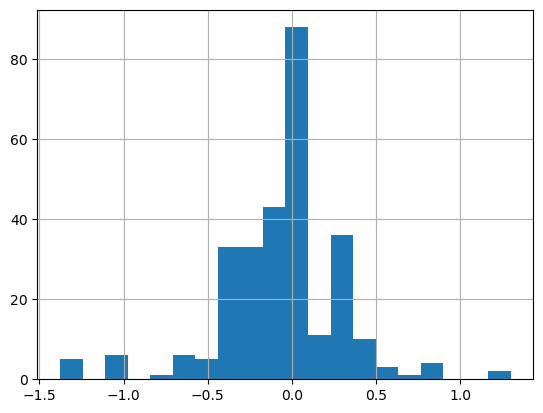

In [164]:
# diff_allexp_allsw['on']['after'].hist(bins=20)
diff_allexp_allsw['on']['sw'].hist(bins=20)

In [165]:
xx=diff_allexp_allsw['on']['sw']
xx.mean()/xx.std()

-0.15828690193113598

sw on
WilcoxonResult(statistic=array([   nan, 17185., 13440.]), pvalue=array([           nan, 1.34272964e-02, 2.84426670e-07]))
sw off
WilcoxonResult(statistic=array([ nan, 526., 418.]), pvalue=array([       nan, 0.53154084, 0.08210634]))


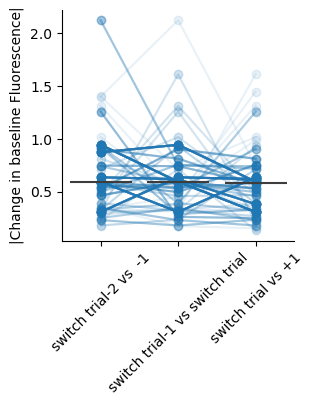

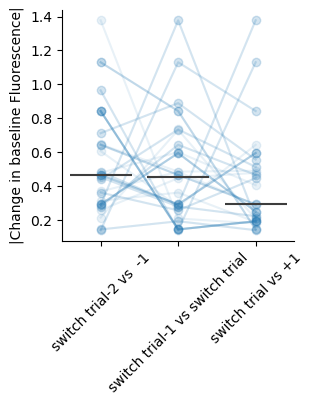

In [166]:

for sw in ['on','off']:
    fig,ax=plt.subplots(figsize=(3,3))
    toplot=F0_change_all_exp_allsw[sw].abs().groupby(level=(0,1)).mean()
    for _,row in toplot.iterrows():
        ncols =len(row)
        ax.plot(np.arange(ncols),row.values,marker='o',c='C0',alpha=0.1)

    ph.median_plot(data=toplot.melt(),x='variable',y='value',ax=ax)

    ax.set_xticks(np.arange(len(toplot.columns)))
    ax.set_xticklabels(['switch trial-2 vs  -1','switch trial-1 vs switch trial','switch trial vs +1'],rotation=45)
    sns.despine()
    ax.set_ylabel('|Change in baseline Fluorescence|')
    ax.set_xlabel('')

    testres=scipy.stats.wilcoxon(diff_allexp_allsw[sw],axis=0)
    print(f'sw {sw}')
    print(testres)

In [ ]:
fig,ax=plt.subplots(figsize=(3,3))
toplot=F0_change_all_exp_allsw['off'].abs().groupby(level=(0,1)).mean()
for _,row in toplot.iterrows():
    ncols =len(row)
    ax.plot(np.arange(ncols),row.values,marker='o',c='C0',alpha=0.1)
    
ph.median_plot(data=toplot.melt(),x='variable',y='value',ax=ax)

ax.set_xticks(np.arange(len(toplot.columns)))
ax.set_xticklabels(['switch trial-2 vs  -1','switch trial-1 vs switch trial','switch trial vs +1'],rotation=45)
sns.despine()
ax.set_ylabel('|Change in baseline Fluorescence|')
ax.set_xlabel('')

testres=scipy.stats.wilcoxon(diff_allexp_allsw['off'],axis=0)

print(testres)

In [83]:
scipy.stats.wilcoxon(diff_allexp_allsw['on'].iloc[:,1])

WilcoxonResult(statistic=12512.0, pvalue=0.07040614919069922)

In [87]:
xx=diff_allexp_allsw['on'].iloc[:,1]
xx.mean()/xx.std()

0.10257239864982946

In [80]:
scipy.stats.wilcoxon(diff_allexp_allsw['on'].iloc[:,2],alternative='less')

WilcoxonResult(statistic=11757.0, pvalue=0.006027546285365866)

In [71]:
F0_change_all_exp_allsw['on'].diff(axis=1).

before        sw     after
0  1   82      NaN  1.202015 -0.329105
       167     NaN -0.361651 -0.941780
       213     NaN  1.556958 -1.699022
       230     NaN -1.107961  0.814119
       245     NaN -0.085001 -1.004953
...            ...       ...       ...
13 166 22      NaN  1.500003 -0.871381
   177 111     NaN -0.167490  0.391691
   180 118     NaN -1.374444  1.382510
14 50  31      NaN  0.875169 -0.910047
   71  25      NaN  0.302912  0.641816

[614 rows x 3 columns]

In [66]:
pd.concat(pval_res_allexp_allsw,axis=0)

0        1      7         8         9         10  \
on  sw_vs_prev  0.190094  0.15625  0.375  0.056351  0.029541  0.677704   
    sw_vs_next  0.760850  0.21875  0.625  0.281047  0.193726  0.746658   
off sw_vs_prev  1.000000  0.50000  1.000  0.684814       NaN  0.764648   
    sw_vs_next  0.500000  1.00000  1.000  0.243896       NaN  0.965820   

                      11   12        13   14  
on  sw_vs_prev  0.869667  NaN  0.034790  1.0  
    sw_vs_next  0.799773  NaN  0.006653  0.5  
off sw_vs_prev  1.000000  1.0  0.500000  NaN  
    sw_vs_next  1.000000  1.0  0.500000  NaN

In [57]:
pd.DataFrame(pval_res_allexp)

{0: {'sw_vs_prev': 0.1900944379158318,
  'sw_vs_next': WilcoxonResult(statistic=247.0, pvalue=0.7608502637594938)},
 1: {'sw_vs_prev': 0.15625,
  'sw_vs_next': WilcoxonResult(statistic=4.0, pvalue=0.21875)},
 7: {'sw_vs_prev': 0.375,
  'sw_vs_next': WilcoxonResult(statistic=3.0, pvalue=0.625)},
 8: {'sw_vs_prev': 0.05635060673810146,
  'sw_vs_next': WilcoxonResult(statistic=3500.0, pvalue=0.28104729524266303)},
 9: {'sw_vs_prev': 0.029541015625,
  'sw_vs_next': WilcoxonResult(statistic=31.0, pvalue=0.1937255859375)},
 10: {'sw_vs_prev': 0.677703857421875,
  'sw_vs_next': WilcoxonResult(statistic=69.0, pvalue=0.7466583251953125)},
 11: {'sw_vs_prev': 0.869666576385498,
  'sw_vs_next': WilcoxonResult(statistic=129.0, pvalue=0.7997725009918213)},
 12: {'sw_vs_prev': nan,
  'sw_vs_next': WilcoxonResult(statistic=nan, pvalue=nan)},
 13: {'sw_vs_prev': 0.0347900390625,
  'sw_vs_next': WilcoxonResult(statistic=21.0, pvalue=0.00665283203125)},
 14: {'sw_vs_prev': 1.0,
  'sw_vs_next': WilcoxonR

# testing functions on individual sessions

### using the looser criteria

In [175]:
exp_ind=0

In [176]:
day_ind = 1
F0_alltrials_allcells = get_F0_one_exp_one_cat(f,exp_ind=exp_ind,day_ind=day_ind,famnov=famnov,region='CA1')
F0_alltrials_allcells = pd.DataFrame(F0_alltrials_allcells)
F0_alltrials_allcells_z = scipy.stats.zscore(F0_alltrials_allcells,axis=1)

In [177]:
get_field_day=day_ind

# get_field_day = 0
threshold_sub = threshold_all.loc[(region,exp_ind,famnov,slice(None),get_field_day)]

all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))

sw_trial_l = get_switch_trial_based_on_mask(
    all_day_activation_sub,
    threshold_sub,
    trial_range = 3,
#     trial_range = 4,
    field_not_present_frac=0.8,
    sw='on',
        )


F0_df = F0_alltrials_allcells_z
F0_change_all,diff = get_F0_change_neighbors(F0_df,dist,sw_trial_l,radius=10)

print(scipy.stats.wilcoxon(diff.iloc[:,1]))
print(scipy.stats.wilcoxon(diff.iloc[:,2]))

/tmp/ipykernel_597304/2271439621.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


KeyError: '[875, 1103] not in index'

In [196]:
sw_trial_l

{(1, 0): 5,
 (21, 1): 3,
 (26, 4): 4,
 (38, 0): 3,
 (47, 1): 3,
 (70, 1): 6,
 (107, 2): 3,
 (134, 1): 3,
 (142, 3): 3,
 (152, 0): 3,
 (160, 0): 3,
 (179, 2): 3,
 (188, 0): 4,
 (202, 0): 3,
 (214, 0): 3,
 (214, 2): 4,
 (250, 2): 3,
 (251, 0): 3,
 (266, 1): 3,
 (266, 2): 3,
 (267, 0): 4,
 (278, 1): 3,
 (302, 0): 3,
 (303, 0): 3,
 (304, 0): 3,
 (305, 0): 3,
 (330, 1): 3,
 (333, 2): 3,
 (356, 3): 8,
 (369, 0): 6,
 (378, 0): 3,
 (399, 0): 3,
 (405, 0): 3,
 (415, 0): 4,
 (421, 0): 3,
 (426, 0): 3,
 (427, 0): 3,
 (440, 1): 3,
 (443, 0): 5,
 (453, 0): 3,
 (457, 0): 3,
 (479, 0): 3,
 (480, 2): 3,
 (489, 0): 3,
 (516, 1): 3,
 (537, 1): 3,
 (537, 2): 3,
 (547, 1): 3,
 (551, 0): 3,
 (551, 1): 8}

<Axes: >

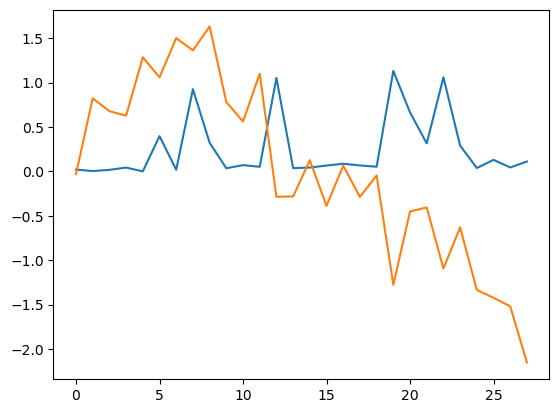

In [197]:
uid=1
all_day_activation_sub.loc[uid,0].plot()
F0_alltrials_allcells_z.loc[uid].plot()

In [195]:
uid=10
scipy.stats.spearmanr(all_day_activation_sub.loc[uid,0].dropna(),F0_alltrials_allcells_z.loc[uid])

SignificanceResult(statistic=0.028461959496442254, pvalue=0.8856829853518466)

In [185]:
scipy.stats.pearsonr(all_day_activation_sub.loc[uid,0].dropna(),F0_alltrials_allcells_z.loc[uid])

PearsonRResult(statistic=0.2512128299144022, pvalue=0.19722996451662322)

In [179]:
F0_alltrials_allcells_z

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.556588,0.950179,-0.027191,-0.100818,1.004194,0.938101,0.629906,0.802891,1.729659,0.064416,...,1.839115,-0.542177,-0.272054,-0.102916,-0.706200,-0.766782,-2.341844,-1.560745,-0.583513,-1.980555
1,-0.030446,0.823626,0.678463,0.628670,1.285874,1.059960,1.501650,1.363491,1.632939,0.781206,...,-0.045214,-1.278190,-0.451584,-0.405881,-1.093827,-0.629972,-1.335634,-1.423858,-1.520043,-2.152770
2,1.366764,-0.079250,0.024266,-1.346455,1.541286,-0.027770,0.934578,1.805674,1.764550,0.290847,...,0.698428,-0.731620,-0.192727,0.184299,-1.016569,-1.313336,-1.395922,-1.564181,-1.301325,-1.561434
3,-0.014090,0.399662,0.315433,-0.441759,-0.028197,0.854808,0.683053,0.068664,1.260357,-0.141749,...,1.963813,0.544351,0.014485,0.144591,-0.359504,-0.842841,-2.762313,-0.871739,-1.926078,-2.246401
4,0.080966,-0.237337,1.055544,0.096024,0.816608,0.697007,0.628308,0.526574,-0.206215,1.145502,...,1.097281,1.254703,-0.772586,-1.085495,-0.157440,-1.761596,-2.346825,-1.493287,-1.218863,-0.904490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,-0.508194,-0.419451,-0.511272,-0.248611,-0.214234,-0.145801,-0.481964,0.024281,-0.166907,-0.314352,...,0.178206,-0.247212,-0.323122,-0.257879,-1.117417,-1.744123,0.955980,2.521406,2.914211,2.236942
570,0.201670,-0.511690,-0.290641,-0.904029,0.396424,-1.378388,0.225257,0.622925,-0.148125,-0.125760,...,-0.670673,-0.815557,0.162048,-0.308390,-2.173060,-1.951594,0.412986,1.523915,2.381604,1.995797
571,-1.073131,-0.639636,-0.469046,-0.989401,-1.225288,-0.465520,-0.081132,-0.093001,0.306686,-0.685435,...,2.528402,0.411252,0.793872,1.317489,-1.761768,-1.861605,-0.828273,0.304280,1.356414,0.381036
572,0.656049,0.063336,0.683277,0.364111,-0.269621,0.207112,0.065988,-0.177682,-0.089954,0.078223,...,0.794301,0.954580,-0.039982,0.573288,1.999935,1.105485,-1.625684,-2.231909,-2.191491,-2.380903


### using the stricter criteria

In [121]:
day_ind = 1
F0_alltrials_allcells = get_F0_one_exp_one_cat(f,exp_ind=exp_ind,day_ind=day_ind,famnov=famnov,region='CA1')
F0_alltrials_allcells = pd.DataFrame(F0_alltrials_allcells)
F0_alltrials_allcells_z = scipy.stats.zscore(F0_alltrials_allcells,axis=1)

In [122]:
### subselect data needed for switch
get_field_day=day_ind

# get_field_day = 0
threshold_sub = threshold_all.loc[(region,exp_ind,famnov,slice(None),get_field_day)]

all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))

# field_not_present_per_trial_sub = field_not_present_per_trial.loc[(region,exp_ind,famnov,slice(None),get_field_day),:].droplevel((0,1,2,4))
# field_present_per_trial_sub=field_not_present_per_trial_sub==False
# field_present_per_trial_sub=field_present_per_trial_sub.astype(int)

field_bounds_sub=field_bounds_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),:].droplevel((0,1,2,4))

### switch detection
sw_on_trial_l=get_switch_trial(
    all_day_activation_sub,
    threshold_sub,
    sw_mag_thresh=0.4,
    trial_range = 5,
    field_present_frac = 0.6,
    field_not_present_frac=0.8,
    sw='on'
    )

/tmp/ipykernel_597304/690380658.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


In [20]:
sw_trial_l = sw_on_trial_l
F0_df = F0_alltrials_allcells_z
F0_change_all,diff = get_F0_change_neighbors(F0_df,dist,sw_trial_l,radius=10)

print(scipy.stats.wilcoxon(diff.iloc[:,1]))
print(scipy.stats.wilcoxon(diff.iloc[:,2]))

Text(0, 0.5, '|Change in baseline Fluorescence|')

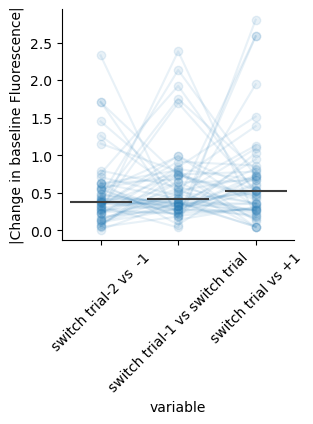

In [30]:
fig,ax=plt.subplots(figsize=(3,3))
toplot=F0_change_all.abs().groupby(level=0).mean()
for _,row in toplot.iterrows():
    ncols =len(row)
    ax.plot(np.arange(ncols),row.values,marker='o',c='C0',alpha=0.1)
    
ph.median_plot(data=toplot.melt(),x='variable',y='value',ax=ax)

ax.set_xticks(np.arange(len(toplot.columns)))
ax.set_xticklabels(['switch trial-2 vs  -1','switch trial-1 vs switch trial','switch trial vs +1'],rotation=45)
sns.despine()
ax.set_ylabel('|Change in baseline Fluorescence|')
# ax.set_xlabel('')

### off

In [111]:
exp_ind=8

In [112]:
day_ind = 0
F0_alltrials_allcells = get_F0_one_exp_one_cat(f,exp_ind=exp_ind,day_ind=day_ind,famnov=famnov,region='CA1')
F0_alltrials_allcells = pd.DataFrame(F0_alltrials_allcells)
F0_alltrials_allcells_z = scipy.stats.zscore(F0_alltrials_allcells,axis=1)

In [115]:
### subselect data needed for switch
get_field_day=day_ind

get_field_day = 0
threshold_sub = threshold_all.loc[(region,exp_ind,famnov,slice(None),get_field_day)]

all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))

# field_not_present_per_trial_sub = field_not_present_per_trial.loc[(region,exp_ind,famnov,slice(None),get_field_day),:].droplevel((0,1,2,4))
# field_present_per_trial_sub=field_not_present_per_trial_sub==False
# field_present_per_trial_sub=field_present_per_trial_sub.astype(int)

field_bounds_sub=field_bounds_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),:].droplevel((0,1,2,4))

### switch detection
sw_on_trial_l=get_switch_trial(
    all_day_activation_sub,
    threshold_sub,
    sw_mag_thresh=0.1,#0.4,
    trial_range = 5,
    field_present_frac = 0.6,
    field_not_present_frac=0.8,
    sw='off'
    )

/tmp/ipykernel_597304/1170245008.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_day_activation_sub=all_day_activation_d_all.loc[(region,exp_ind,famnov,slice(None),get_field_day),('within',get_field_day)].droplevel((0,1,2,4))


In [37]:
sw_trial_l = sw_on_trial_l
F0_df = F0_alltrials_allcells_z
F0_change_all,diff = get_F0_change_neighbors(F0_df,dist,sw_trial_l,radius=10)

print(scipy.stats.wilcoxon(diff.iloc[:,1]))
print(scipy.stats.wilcoxon(diff.iloc[:,2]))

WilcoxonResult(statistic=39.0, pvalue=0.684814453125)
WilcoxonResult(statistic=28.0, pvalue=0.243896484375)


Text(0, 0.5, '|Change in baseline Fluorescence|')

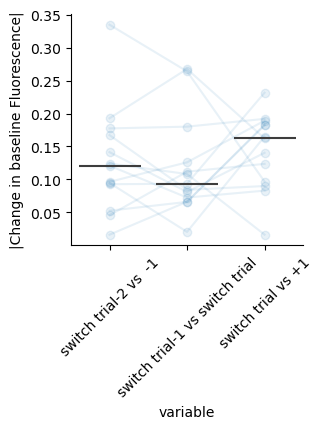

In [38]:
fig,ax=plt.subplots(figsize=(3,3))
toplot=F0_change_all.abs().groupby(level=0).mean()
for _,row in toplot.iterrows():
    ncols =len(row)
    ax.plot(np.arange(ncols),row.values,marker='o',c='C0',alpha=0.1)
    
ph.median_plot(data=toplot.melt(),x='variable',y='value',ax=ax)

ax.set_xticks(np.arange(len(toplot.columns)))
ax.set_xticklabels(['switch trial-2 vs  -1','switch trial-1 vs switch trial','switch trial vs +1'],rotation=45)
sns.despine()
ax.set_ylabel('|Change in baseline Fluorescence|')
# ax.set_xlabel('')

In [210]:
(pval_all<0.05).mean()


0.6356589147286822

In [211]:
F0_change_uid_close_sw

271   -1.663088
454    1.433086
468   -0.865235
473   -1.448479
490    0.710277
525    1.756959
Name: 8, dtype: float64

In [212]:
F0_change_uid_close_othertr.abs() - F0_change_uid_close_sw.abs().values[:,None]

,1,2,3,4,5,6,7,9,10,11,...,18,19,20,21,22,23,24,25,26,27
271,-0.147254,-0.633983,-1.517317,-1.606901,-1.583208,-0.982589,-0.771342,1.954006,-0.301981,0.618194,...,-0.742939,0.728793,-0.085912,-0.611313,1.744457,0.520443,-0.111739,-0.059898,-1.623032,-1.460979
454,-0.857429,-1.324724,-1.407943,-0.315637,-0.100671,-1.124145,-0.157430,-1.321438,-1.325989,-1.032986,...,1.066317,-0.770723,0.233880,-0.942892,-1.307744,-0.644340,2.033777,-1.097448,-0.790578,-0.197535
468,1.123736,0.882913,0.267468,-0.100449,0.493242,-0.287653,0.411365,0.807080,-0.742919,0.649204,...,2.067182,1.818609,-0.531546,0.280271,1.131768,-0.226778,0.947322,0.353855,-0.292041,-0.171965
473,-0.999236,-1.102303,-0.880297,-0.402496,-0.192137,-1.305012,-1.299333,0.717552,-0.819646,-0.258153,...,-1.129978,-1.348733,-1.436059,-1.261956,0.171500,-0.119186,-1.291405,-0.648244,-1.289894,-0.971620
490,0.430367,-0.229182,-0.684974,0.253863,1.358468,-0.176522,0.203254,0.414329,0.595017,-0.613643,...,2.190536,1.616372,0.689966,1.238561,-0.649781,-0.194948,0.803721,0.162373,-0.409680,-0.121740
525,-0.711914,-0.557965,-1.442764,-0.397216,0.202254,-0.865580,-1.741524,-0.991190,-1.396419,-0.467342,...,-0.850264,-0.887803,-1.432851,-1.145284,-0.506931,-1.067834,-0.560631,-0.958056,-1.464820,-0.890392


In [23]:
xx=F0_change_uid_close_othertr.abs() - F0_change_uid_close_sw.abs().values[:,None]
scipy.stats.wilcoxon(xx.T)

WilcoxonResult(statistic=array([127.,   0.,  52., 154.,  21.,  18., 155.,  13.,   0.,  60.,  24.,
       108., 152.,  48.,  58.,  73.,  50., 175.,   0., 174.,   3.,   1.,
       162., 155.,  52.,   1.,  36.,  14.,  49., 130.,   7.,  27., 153.,
        18.,  16.,  89., 153.,   0., 161.,  51., 155.,   3.,   0., 104.,
        83.,  58., 103., 116., 122., 168.,  40.,   0., 139., 111.,   0.,
        16., 129.,  38., 136., 143.,  90., 115., 129.,  81.,   1., 160.,
        52., 169., 122.,   6., 166., 125.,   2., 109.,   4., 132.,  93.,
        14., 100.,  90.,   0.,  99.,  99.,  63., 163.,  26.,  81.,  32.,
        12.,   3., 106.,  18.,  73.,  11., 170., 126.,  32.,  57.,  74.,
       145.,  69.,  54.,  13., 100.,   0.,   1., 117.,  25.,  52.,   6.,
        96., 148.,  60.,  97.,  22., 103.,   1.,  92.,   2.,  10.,  76.,
        49.,   3., 154.,  55.,  58.,   1.,  34.,  32., 126.,  24.,  63.,
        52.,  18.,   9.,  91.,  10., 165.,   5., 137.,  77., 146.,  68.,
       150.,  27.,  29.,  

In [171]:
F0_df_diff=F0_df.diff(axis=1)

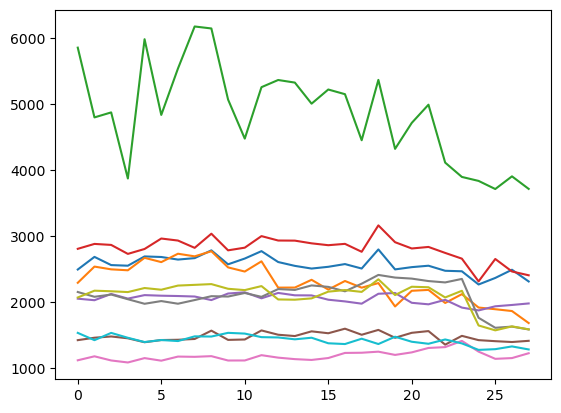

In [20]:
for i in range(10):
    F0_alltrials_allcells.iloc[i].plot()

<Axes: >

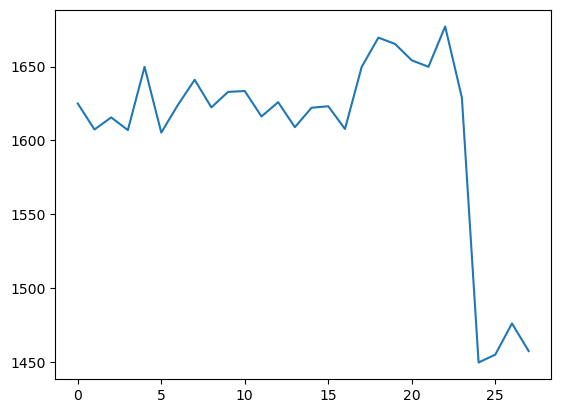

In [21]:
F0_alltrials_allcells.median(axis=0).plot()

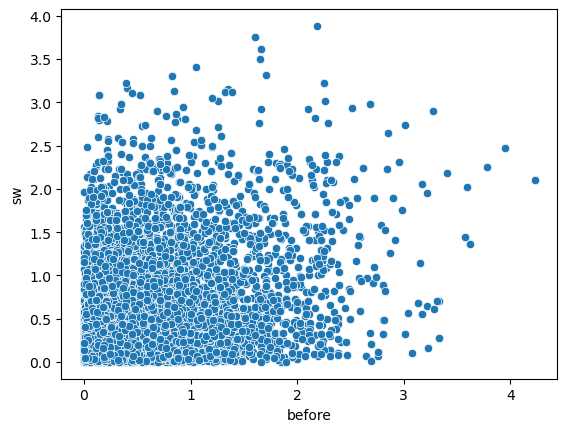

In [28]:
ax=sns.scatterplot(data=F0_change_all.abs(),x='before',y='sw')
# ax.set_xlim([0,400])
# ax.set_ylim([0,400])

In [32]:
xx=F0_change_all.dropna(axis=0).abs().diff(axis=1).iloc[:,1]
xx.mean()/xx.std()

0.0330336035845691

In [29]:
xx=F0_change_all.dropna(axis=0).abs().diff(axis=1).iloc[:,1]
scipy.stats.wilcoxon(xx,alternative='greater')

WilcoxonResult(statistic=76497113.0, pvalue=3.038269638137495e-08)

In [30]:
xx=F0_change_all.dropna(axis=0).abs().diff(axis=1).iloc[:,2]
scipy.stats.wilcoxon(xx,alternative='greater')

WilcoxonResult(statistic=74937322.0, pvalue=0.0013600030384474406)

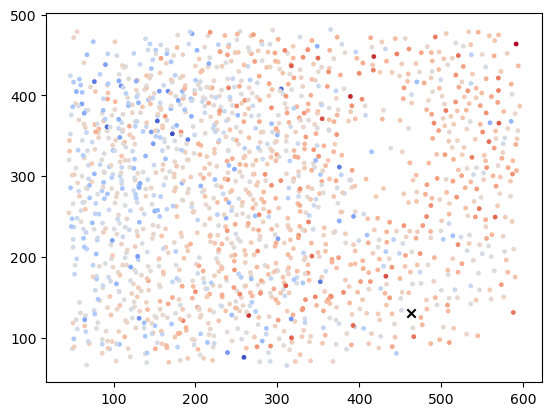

In [159]:
ii=12
# anchor_id = prepost_maxfr_mean_relative_to_eachsw.index.get_level_values(0).unique()[ii]

anchor_id=list(sw_on_trial_l.keys())[ii][0]
# anchor_id=1

# # roi for all neurons
# plt.scatter(roi_com_all[:,0],roi_com_all[:,1])

# ma =dist.loc[anchor_id] < 10
# uid_close=ma.index[ma]
uid_close=F0_change_all.loc[anchor_id].index
diff_sub=F0_change_all.loc[anchor_id]['sw']
# diff_sub.loc[anchor_id] = prepost_maxfr_mean_relative_to_eachsw.loc[anchor_id]['in_field_gain'].unique()[0]

import matplotlib.colors as mcolors
norm = mcolors.TwoSlopeNorm(0)
plt.scatter(roi_com_all[diff_sub.index,0],roi_com_all[diff_sub.index,1],c=diff_sub.values,cmap='coolwarm',norm=norm,
            s=6
           )


plt.scatter(roi_com_all[anchor_id,0],roi_com_all[anchor_id,1],c='black',marker='x')

In [29]:
# for each switch on, get the change in mean dF/F in adjacent neurons/population

fr_map_trial_df_sub = fr_map_trial_df_sub_z

prepost_maxfr_mean_relative_to_eachsw = {}

for (uid,field_id), tr in sw_on_trial_l.items():

    # field boundary
    field_st,field_ed=field_bounds_sub.loc[uid,field_id][['start','end']]
    field_slice=slice(field_st,field_ed) 
    
#     ma =dist.loc[uid] < 1000
    ma =dist.loc[uid] < 10
    uid_close=ma.index[ma]
    
    uid_close=uid_close.difference(sw_on_uid_onesess)
#     np.sum(ma)

#     pre_maxfr_mean = fr_map_trial_df_sub.loc[uid_close].iloc[:,:trial_range].groupby(level=0).mean().mean(axis=1)
#     post_maxfr_mean=fr_map_trial_df_sub.loc[uid_close].iloc[:,trial_range:trial_range*2].groupby(level=0).mean().mean(axis=1)
    
    in_field_prev=fr_map_trial_df_sub.loc[(uid,field_slice),tr-1].mean()
    in_field_gain =fr_map_trial_df_sub.loc[(uid,field_slice),tr].mean() - in_field_prev
    in_field_gain_ratio_prev=in_field_gain / (in_field_prev+1e-10)
    post_field_std=fr_map_trial_df_sub.loc[(uid,field_slice),(tr+1):].mean().std()

    
    pre_meanfr_mean = fr_map_trial_df_sub.loc[uid_close].loc[(slice(None),field_slice),(tr-1):(tr-1)].groupby(level=0).mean().mean(axis=1)
    post_meanfr_mean=fr_map_trial_df_sub.loc[uid_close].loc[(slice(None),field_slice),tr:(tr)].groupby(level=0).mean().mean(axis=1)
    
    post_meanfr_std=fr_map_trial_df_sub.loc[uid_close].loc[(slice(None),field_slice),(tr+1):].groupby(level=0).mean().std(axis=1)

    prepost_maxfr_mean=pd.concat({'pre':pre_meanfr_mean,'post':post_meanfr_mean,'post_std':post_meanfr_std},axis=1)
    
    prepost_maxfr_mean['in_field_gain'] = in_field_gain
    prepost_maxfr_mean['in_field_gain_ratio_prev']=in_field_gain_ratio_prev
    prepost_maxfr_mean['post_field_std'] = post_field_std
    
    prepost_maxfr_mean_relative_to_eachsw[uid] = prepost_maxfr_mean
prepost_maxfr_mean_relative_to_eachsw = pd.concat(prepost_maxfr_mean_relative_to_eachsw,axis=0)
    
    


In [ ]:
# for each switch on, get the change in mean dF/F in adjacent neurons/population

fr_map_trial_df_sub = fr_map_trial_df_sub_z

prepost_maxfr_mean_relative_to_eachsw = {}

for (uid,field_id), tr in sw_on_trial_l.items():

    # field boundary
    field_st,field_ed=field_bounds_sub.loc[uid,field_id][['start','end']]
    field_slice=slice(field_st,field_ed) 
    
#     ma =dist.loc[uid] < 1000
    ma =dist.loc[uid] < 10
    uid_close=ma.index[ma]
    
    uid_close=uid_close.difference(sw_on_uid_onesess)
#     np.sum(ma)

#     pre_maxfr_mean = fr_map_trial_df_sub.loc[uid_close].iloc[:,:trial_range].groupby(level=0).mean().mean(axis=1)
#     post_maxfr_mean=fr_map_trial_df_sub.loc[uid_close].iloc[:,trial_range:trial_range*2].groupby(level=0).mean().mean(axis=1)
    
    in_field_prev=fr_map_trial_df_sub.loc[(uid,field_slice),tr-1].mean()
    in_field_gain =fr_map_trial_df_sub.loc[(uid,field_slice),tr].mean() - in_field_prev
    in_field_gain_ratio_prev=in_field_gain / (in_field_prev+1e-10)
    post_field_std=fr_map_trial_df_sub.loc[(uid,field_slice),(tr+1):].mean().std()

    
    pre_meanfr_mean = fr_map_trial_df_sub.loc[uid_close].loc[(slice(None),field_slice),(tr-1):(tr-1)].groupby(level=0).mean().mean(axis=1)
    post_meanfr_mean=fr_map_trial_df_sub.loc[uid_close].loc[(slice(None),field_slice),tr:(tr)].groupby(level=0).mean().mean(axis=1)
    
    post_meanfr_std=fr_map_trial_df_sub.loc[uid_close].loc[(slice(None),field_slice),(tr+1):].groupby(level=0).mean().std(axis=1)

    prepost_maxfr_mean=pd.concat({'pre':pre_meanfr_mean,'post':post_meanfr_mean,'post_std':post_meanfr_std},axis=1)
    
    prepost_maxfr_mean['in_field_gain'] = in_field_gain
    prepost_maxfr_mean['in_field_gain_ratio_prev']=in_field_gain_ratio_prev
    prepost_maxfr_mean['post_field_std'] = post_field_std
    
    prepost_maxfr_mean_relative_to_eachsw[uid] = prepost_maxfr_mean
prepost_maxfr_mean_relative_to_eachsw = pd.concat(prepost_maxfr_mean_relative_to_eachsw,axis=0)
    
    


In [17]:
# a bunch of post processing; might not all be important; was exploring
prepost_maxfr_mean_relative_to_eachsw['diff'] =prepost_maxfr_mean_relative_to_eachsw['post']-prepost_maxfr_mean_relative_to_eachsw['pre']
prepost_maxfr_mean_relative_to_eachsw['ratio'] = prepost_maxfr_mean_relative_to_eachsw['diff'] / prepost_maxfr_mean_relative_to_eachsw['post_std']
prepost_maxfr_mean_relative_to_eachsw['ratio'] = prepost_maxfr_mean_relative_to_eachsw['ratio'].abs()
prepost_maxfr_mean_relative_to_eachsw['ratio_prev']=prepost_maxfr_mean_relative_to_eachsw['diff'] / (prepost_maxfr_mean_relative_to_eachsw['pre']+1e-10)
prepost_maxfr_mean_relative_to_eachsw['field_ratio']=prepost_maxfr_mean_relative_to_eachsw['in_field_gain'] / prepost_maxfr_mean_relative_to_eachsw['post_field_std']



<Axes: >

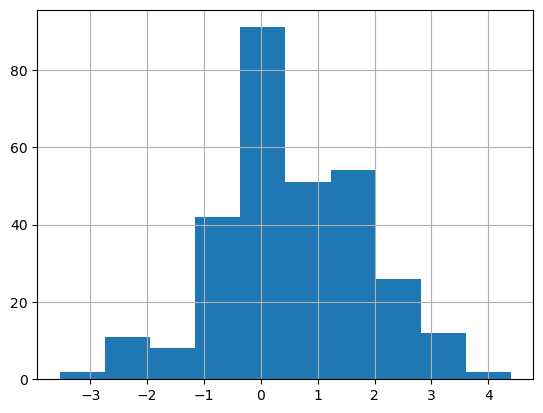

In [818]:
prepost_maxfr_mean_relative_to_eachsw['diff'].hist()

<Axes: >

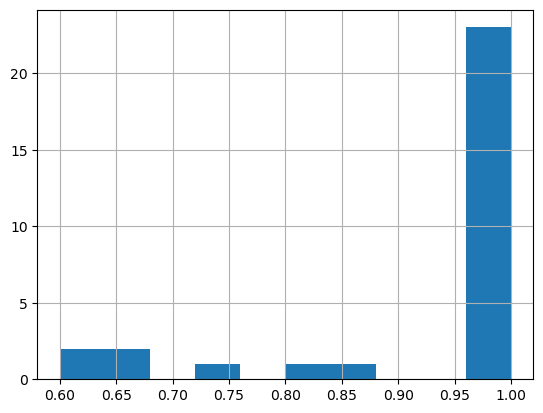

In [567]:
# # abandoned idea: if the change is within 3 std, maybe not considered big enough? but then the switch on often is not outside of 3 std either;
# prepost_maxfr_mean_relative_to_eachsw.groupby(level=0).apply(lambda x:(x['ratio']<3).mean()).hist()

In [768]:
sw_on_trial_l

{(0, 1): 6,
 (16, 2): 5,
 (19, 0): 8,
 (44, 0): 7,
 (45, 0): 7,
 (49, 0): 6,
 (59, 0): 5,
 (70, 0): 10,
 (85, 0): 7,
 (118, 1): 11,
 (134, 0): 12,
 (155, 1): 11,
 (162, 1): 5,
 (165, 0): 5,
 (191, 1): 10,
 (209, 0): 8,
 (215, 0): 7,
 (216, 0): 5,
 (222, 0): 5,
 (261, 1): 12,
 (271, 0): 9,
 (272, 1): 5,
 (280, 0): 11,
 (282, 0): 9,
 (285, 1): 9,
 (304, 1): 5,
 (306, 0): 5,
 (307, 0): 10,
 (314, 0): 5,
 (316, 1): 6,
 (321, 0): 10,
 (321, 2): 10,
 (326, 1): 8,
 (333, 0): 9,
 (365, 1): 5,
 (369, 1): 11,
 (390, 0): 7,
 (392, 0): 9,
 (398, 0): 9,
 (405, 1): 5,
 (408, 1): 11,
 (455, 0): 5,
 (474, 1): 5,
 (475, 0): 6,
 (505, 0): 9,
 (534, 2): 8,
 (542, 0): 9,
 (543, 0): 5,
 (547, 0): 5,
 (548, 0): 5,
 (552, 0): 5,
 (555, 0): 11,
 (559, 0): 5,
 (568, 0): 9,
 (649, 0): 5,
 (667, 0): 5,
 (670, 0): 6,
 (676, 0): 6,
 (708, 2): 9,
 (733, 1): 5,
 (741, 0): 8,
 (748, 1): 5,
 (765, 0): 7,
 (801, 0): 12,
 (812, 0): 6,
 (837, 0): 11,
 (841, 0): 5,
 (861, 0): 6,
 (887, 0): 10,
 (898, 2): 11,
 (909, 0): 5,

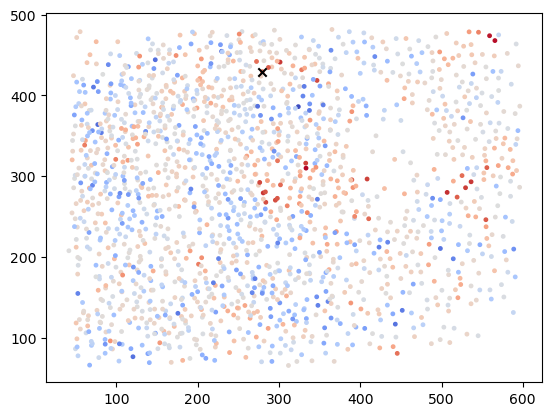

In [786]:
ii=20
# anchor_id = prepost_maxfr_mean_relative_to_eachsw.index.get_level_values(0).unique()[ii]

# anchor_id=list(sw_on_trial_l.keys())[ii][0]
anchor_id=475

# # roi for all neurons
# plt.scatter(roi_com_all[:,0],roi_com_all[:,1])

# ma =dist.loc[anchor_id] < 10
# uid_close=ma.index[ma]
uid_close=prepost_maxfr_mean_relative_to_eachsw.loc[anchor_id].index
diff_sub=prepost_maxfr_mean_relative_to_eachsw.loc[anchor_id]['diff']
diff_sub.loc[anchor_id] = prepost_maxfr_mean_relative_to_eachsw.loc[anchor_id]['in_field_gain'].unique()[0]

import matplotlib.colors as mcolors
norm = mcolors.TwoSlopeNorm(0)
plt.scatter(roi_com_all[diff_sub.index,0],roi_com_all[diff_sub.index,1],c=diff_sub.values,cmap='coolwarm',norm=norm,
            s=6
           )


plt.scatter(roi_com_all[anchor_id,0],roi_com_all[anchor_id,1],c='black',marker='x')

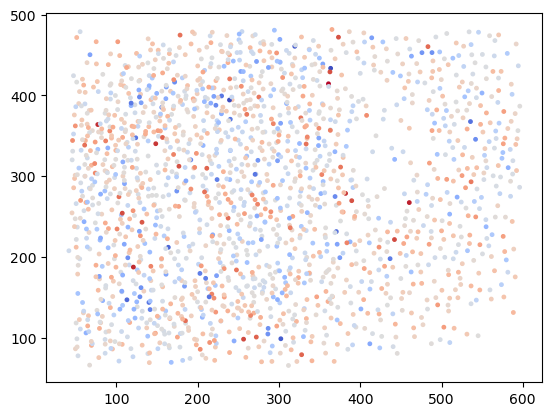

In [814]:
# taking a chunk of space, look at the change in dF with the last trial, its distribution in space; just very spatially smooth 
tr=11
change_all_neuron=fr_map_trial_df_sub_z.loc[(slice(None),slice(0,10)),:].groupby(level=0).mean().diff(axis=1)[tr]

import matplotlib.colors as mcolors
norm = mcolors.TwoSlopeNorm(0)
plt.scatter(roi_com_all[change_all_neuron.index,0],roi_com_all[change_all_neuron.index,1],c=change_all_neuron.values,cmap='coolwarm',norm=norm,
            s=6
           )


In [ ]:
change_all_neuron

<Axes: >

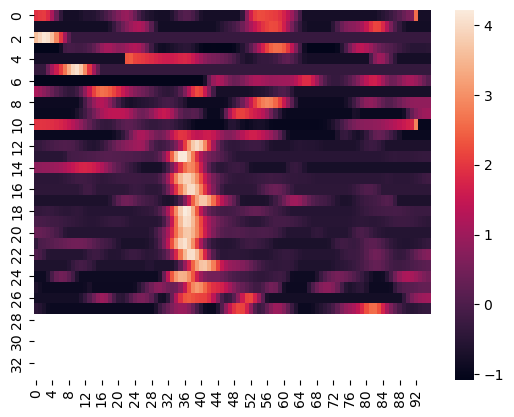

In [761]:
sns.heatmap(fr_map_trial_df_sub.loc[anchor_id].T)

In [659]:
prepost_maxfr_mean_relative_to_eachsw.loc[anchor_id]

,pre,post,post_std,in_field_gain,in_field_gain_ratio_prev,post_field_std,diff,ratio,ratio_prev,field_ratio
0,0.001887,-0.544666,1.376395,0.041199,-0.092889,1.161028,-0.546553,0.397090,-289.630449,0.035485
2,0.347053,-1.022660,1.236227,0.041199,-0.092889,1.161028,-1.369713,1.107979,-3.946697,0.035485
3,0.123155,0.520710,1.250717,0.041199,-0.092889,1.161028,0.397555,0.317862,3.228091,0.035485
4,-0.332746,-1.251578,0.900392,0.041199,-0.092889,1.161028,-0.918832,1.020481,2.761366,0.035485
5,-0.526166,-0.451991,0.446051,0.041199,-0.092889,1.161028,0.074175,0.166294,-0.140973,0.035485
...,...,...,...,...,...,...,...,...,...,...
569,-0.755290,-1.245018,1.024909,0.041199,-0.092889,1.161028,-0.489728,0.477826,0.648398,0.035485
570,1.391008,0.218141,1.342847,0.041199,-0.092889,1.161028,-1.172867,0.873418,-0.843177,0.035485
571,-0.691727,2.167892,1.140181,0.041199,-0.092889,1.161028,2.859620,2.508039,-4.134027,0.035485
572,-0.011377,-0.692707,0.568769,0.041199,-0.092889,1.161028,-0.681330,1.197902,59.889135,0.035485


In [568]:
diff=prepost_maxfr_mean_relative_to_eachsw['post']-prepost_maxfr_mean_relative_to_eachsw['pre']


In [569]:
scipy.stats.wilcoxon(diff)

WilcoxonResult(statistic=1661.0, pvalue=1.2805600760504894e-05)

<Axes: >

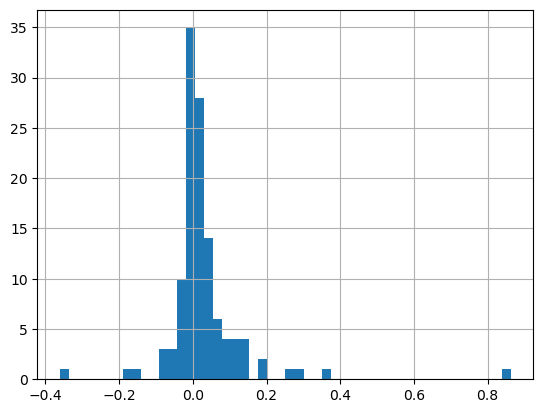

In [570]:
diff.hist(bins=50)

<Axes: xlabel='pre', ylabel='post'>

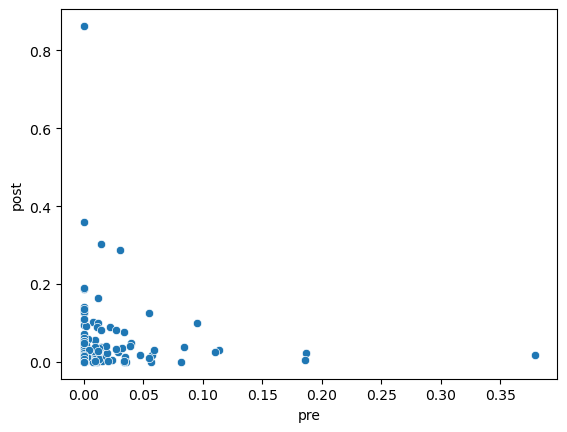

In [571]:
sns.scatterplot(data=prepost_maxfr_mean_relative_to_eachsw,x='pre',y='post')

In [292]:
all_day_activation_d_all

within                                \
                                     0                                 
                                    0         1         2         3    
             get_field_day                                             
CA1 0  0 0   0             0  0.184225  0.130069  0.023486  0.106299   
                           1  0.000000  0.053595  0.078478  0.098637   
             1             0  0.062672  0.188146  0.012457  0.171355   
                           1  0.000000  0.067790  0.092780  0.104951   
         1   0             0  1.144251  0.224361  0.216527  0.000000   
...                                ...       ...       ...       ...   
DG  11 1 218 0             2  0.011088  0.007732  0.004561  0.030925   
         220 0             0  0.010905  0.000101  0.033949  0.006510   
                           1  0.039299  0.029092  0.002359  0.014740   
             1             0  0.041503  0.037467  0.003258  0.014869   
         221 1             0  0.026309  0.055261  0.001463  0.000000   

                                                                      \
                                                                       
                                    4         5         6         7    
             get_field_day                                             
CA1 0  0 0   0             0  0.013915  0.080054  0.316622  0.190915   
                           1  0.135115  0.074730  0.043225  0.336811   
             1             0  0.010061  0.179048  0.570559  0.305783   
                           1  0.125853  0.064162  0.030913  0.227060   
         1   0             0  0.048694  0.076712  0.063552  0.015769   
...                                ...       ...       ...       ...   
DG  11 1 218 0             2  0.017382  0.002384  0.012345  0.016073   
         220 0             0  0.062650  0.014683  0.019635  0.045571   
                           1  0.027902  0.245931  0.058940  0.042360   
             1             0  0.035499  0.316909  0.060549  0.057794   
         221 1             0  0.000000  0.000000  0.005388  0.000000   

                                                  ... diff within          \
                                                  ...    1      0           
                                    8         9   ...   33     30  31  32   
             get_field_day                        ...                       
CA1 0  0 0   0             0  0.097365  0.063850  ...  NaN    NaN NaN NaN   
                           1  0.017386  0.216187  ...  NaN    NaN NaN NaN   
             1             0  0.157423  0.100661  ...  NaN    NaN NaN NaN   
                           1  0.031310  0.155983  ...  NaN    NaN NaN NaN   
         1   0             0  0.016236  0.000162  ...  NaN    NaN NaN NaN   
...                                ...       ...  ...  ...    ...  ..  ..   
DG  11 1 218 0             2  0.018500  0.021576  ...  NaN    NaN NaN NaN   
         220 0             0  0.031437  0.039007  ...  NaN    NaN NaN NaN   
                           1  0.026591  0.051402  ...  NaN    NaN NaN NaN   
             1             0  0.032788  0.068913  ...  NaN    NaN NaN NaN   
         221 1             0  0.026660  0.051700  ...  NaN    NaN NaN NaN   

                             outside         diff          
                                   0            0          
                                  30  31  32   30  31  32  
             get_field_day                                 
CA1 0  0 0   0             0     NaN NaN NaN  NaN NaN NaN  
                           1     NaN NaN NaN  NaN NaN NaN  
             1             0     NaN NaN NaN  NaN NaN NaN  
                           1     NaN NaN NaN  NaN NaN NaN  
         1   0             0     NaN NaN NaN  NaN NaN NaN  
...                              ...  ..  ..  ...  ..  ..  
DG  11 1 218 0             2     NaN NaN NaN  NaN NaN NaN  
         220 0             0     NaN NaN NaN  NaN NaN 

/tmp/ipykernel_398524/1546380430.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  xx=all_day_activation_d_all.loc[(region,exp_ind,famnov,uid,get_field_day,0),('within',day_ind)]


<Axes: >

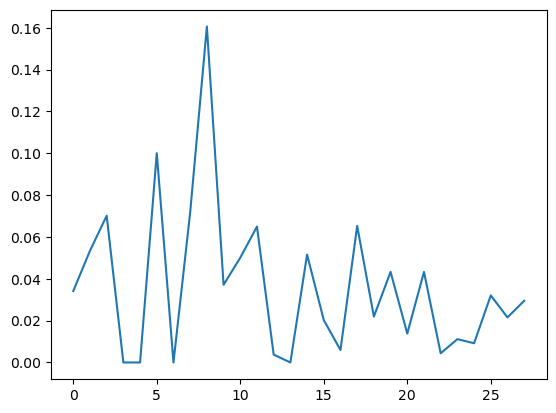

In [339]:
get_field_day=1
uid=35
xx=all_day_activation_d_all.loc[(region,exp_ind,famnov,uid,get_field_day,0),('within',day_ind)]
# np.log(xx).plot()
xx.plot()

/tmp/ipykernel_398524/2846966288.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df_sub=fr_map_trial_df_all.loc[(region,exp_ind,day_ind,famnov),:]


In [196]:


prepost_maxfr_mean_relative_to_eachsw = {}

for uid in sw_on_uid_onesess:
    ma =dist.loc[uid] < 20
    uid_close=ma.index[ma]
    
    uid_close=uid_close.difference(sw_on_uid_onesess)
#     np.sum(ma)

#     pre_maxfr_mean = fr_map_trial_df_sub.loc[uid_close].iloc[:,:trial_range].groupby(level=0).mean().mean(axis=1)
#     post_maxfr_mean=fr_map_trial_df_sub.loc[uid_close].iloc[:,trial_range:trial_range*2].groupby(level=0).mean().mean(axis=1)
    
    fr_map_trial_df_sub.loc[uid].iloc[:,trial_range:trial_range*1].mean().mean(axis=1)
    
    pre_maxfr_mean = fr_map_trial_df_sub.loc[uid_close].iloc[:,0:trial_range*1].groupby(level=0).mean().mean(axis=1)
    post_maxfr_mean=fr_map_trial_df_sub.loc[uid_close].iloc[:,trial_range*1:trial_range*2].groupby(level=0).mean().mean(axis=1)

    prepost_maxfr_mean=pd.concat({'pre':pre_maxfr_mean,'post':post_maxfr_mean},axis=1)
    
    prepost_maxfr_mean_relative_to_eachsw[uid] = prepost_maxfr_mean
prepost_maxfr_mean_relative_to_eachsw = pd.concat(prepost_maxfr_mean_relative_to_eachsw,axis=0)
    
    

<Axes: >

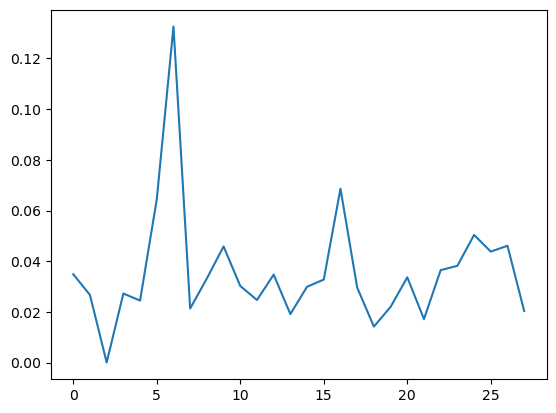

In [281]:
fr_map_trial_df_sub.loc[11].mean(axis=0).plot()

In [240]:
uid_close

Int64Index([171, 175, 226, 240, 271, 280, 445, 451, 453, 454, 467, 468, 472,
            473, 490, 500, 505, 515, 525, 526, 553, 557, 573],
           dtype='int64')

/mnt/home/szheng/miniconda3/envs/jaxnew/lib/python3.10/site-packages/seaborn/matrix.py:213: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


<Axes: >

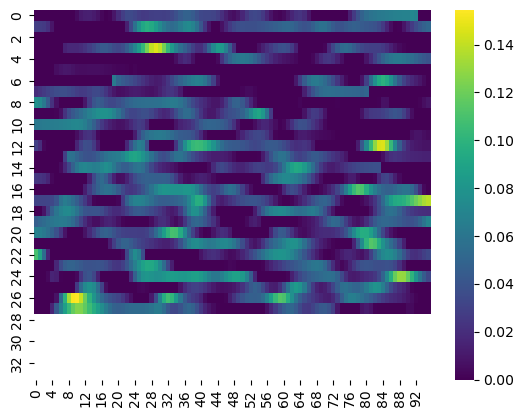

In [263]:
sns.heatmap(fr_map_trial_df_sub.loc[573].T,cmap='viridis')

In [210]:
fr_map_trial_df_sub.loc[uid].iloc[:,trial_range*1:trial_range*2].mean().mean()

0.0625231315752623

In [198]:
sw_on_uid_onesess

Int64Index([  1,  24,  26,  55,  70, 188, 204, 214, 214, 266, 267, 278, 304,
            305, 306, 333, 335, 344, 356, 369, 373, 378, 399, 403, 415, 421,
            426, 443, 457, 465, 466, 495, 514, 516, 519, 537, 547, 551],
           dtype='int64')

In [199]:
diff=prepost_maxfr_mean_relative_to_eachsw['post']-prepost_maxfr_mean_relative_to_eachsw['pre']
scipy.stats.wilcoxon(diff)


WilcoxonResult(statistic=100166.0, pvalue=0.32845401940620267)

<Axes: >

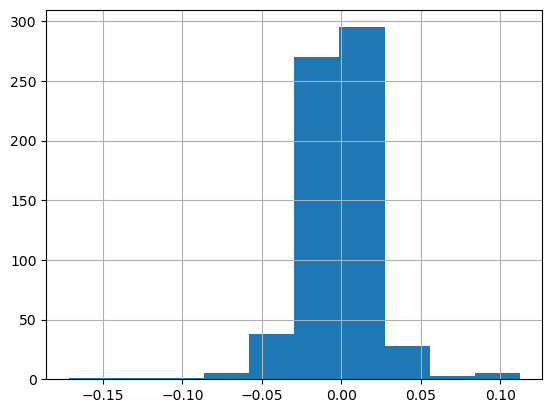

In [200]:
diff.hist()

<Axes: xlabel='pre', ylabel='post'>

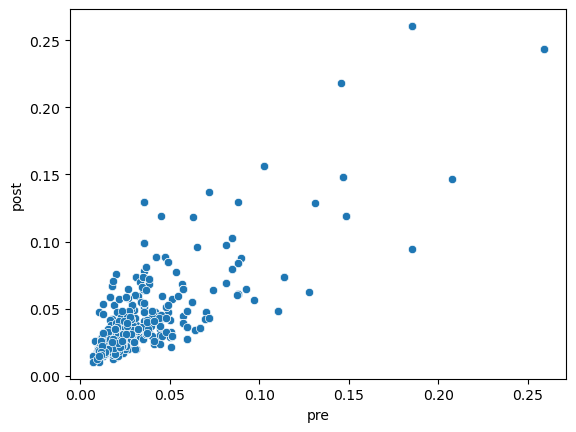

In [189]:
sns.scatterplot(data=prepost_maxfr_mean_relative_to_eachsw,x='pre',y='post')

In [158]:
pre_maxfr_mean = fr_map_trial_df_sub.loc[uid_close].iloc[:,:trial_range].groupby(level=0).max().mean(axis=1)
post_maxfr_mean=fr_map_trial_df_sub.loc[uid_close].iloc[:,trial_range:trial_range*2].groupby(level=0).max().mean(axis=1)
prepost_maxfr_mean=pd.concat({'pre':pre_maxfr_mean,'post':post_maxfr_mean},axis=1)



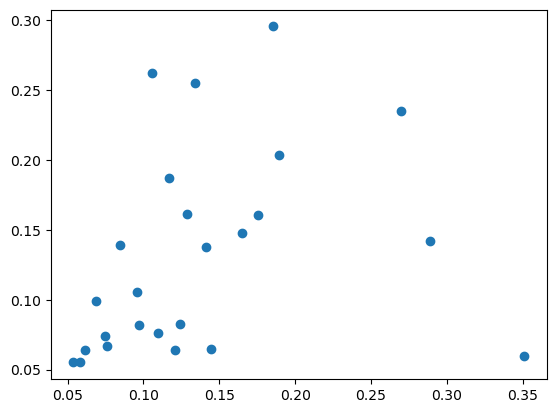

In [157]:
plt.scatter(pre_maxfr_mean,post_maxfr_mean)

/tmp/ipykernel_398524/2846966288.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df_sub=fr_map_trial_df_all.loc[(region,exp_ind,day_ind,famnov),:]


In [117]:
ma

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [116]:
fr_map_trial_df_sub.loc[ma]

ValueError: Item wrong length 26 instead of 55104.

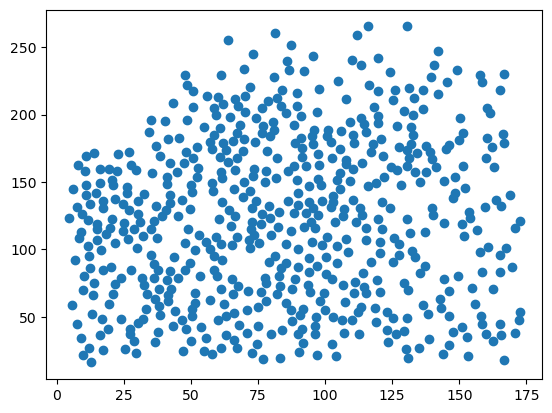

In [98]:
plt.scatter(roi_com_all[:,0],roi_com_all[:,1])

(array([12599., 27645., 34664., 33352., 26299., 17355.,  8464.,  3202.,
          800.,    71.]),
 array([  3.22132411,  30.48020764,  57.73909116,  84.99797469,
        112.25685822, 139.51574175, 166.77462527, 194.0335088 ,
        221.29239233, 248.55127586, 275.81015939]),
 <BarContainer object of 10 artists>)

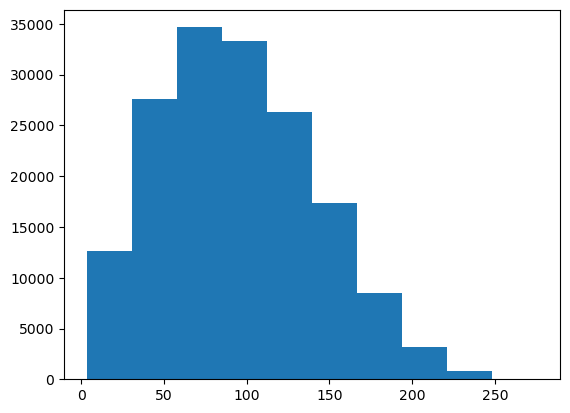

In [101]:
plt.hist(squareform(dist))

In [60]:
mnCooordinates.mean(axis=1)

array([  9.11111111, 113.22222222])